# Titanic passengers survival analysis Kaggle competition

In this notebook we will conduct data analysis and predictive modelling of Titanic passengers survival dataset for Kaggle [Titanic dataset](https://www.kaggle.com/c/titanic).

Titanic passengers survival dataset is one of the most canonical data analysis and machine learning datasets. Let's see how this data looks like, investigate main trends in it and try to predict survival chances of passengers based on numerous features.

The main steps of the analysis process we will conduct are:
1. Frame the problem
2. Get the data
3. Explore the data
4. Prepare the data for machine learning algorithms
5. Select a model and train it
6. Fine-tune the model
7. Submit solution

In [1]:
import numpy as np

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from pywaffle import Waffle

import warnings
warnings.filterwarnings('ignore')

## 1. Frame the problem

Titanic sinking was one of the biggest shipwreck tragedies in history. It killed 1502 out of 2224 passengers. This tragedy led to better safety regulations for ships. The main reason for such a great death toll was not enough number of lifeboats to fit all passengers. This can lead to the conclusion that some groups of people were more likely to survive than others - woman, children and upper-class passeners for example.

### 1.1 The goal

The goal of this analysis is two fold. Firstly, we want to analyse the data set, explore it answering related questions using statistical methods and data visualization. Secondly our goal is to predict which passengers were likely to survive Titanic catastrophy and which not. For each `PassengerId` in the provided unlabeled test set, we want to predict a whether given passenger survived or not.

### 1.2 Analysis

There are some questions we would like to answer with Titanic dataset analysis.

* What is Titanic passengers demographic structure analyzed in terms of attributes?

* What is the overall Titanic passengers survival ratio? Is the difference between survived group statistically significant as compared to the rest of population?

* What is the survival ratio for different demographic passengers groups? Which groups have biggest chances for survival and which smallest? Were the differences between the most distinct groups statistically significant? 

### 1.3 Modeling

As for second goal, since we are given multiple features data with labeled survival values this is clearly an supervised learning problem. Moreover we try to predict discrete categorical value: 0 or 1 (representing not-survived and survived passenger). This tells us that we deal here with binary categorization problem.

As a measure of created machine learning models performance we choose the percentage of passengers we correctly predict, that is accuracy level.

As a final product we will prepare and submit a csv file with predicted survival for exactly 418 entries in the test dataset. The file should have exactly 2 columns:
* PassengerId (sorted in any order)
* Survived (contains your binary predictions: 1 for survived, 0 for deceased)

The example submission dataset should look like this:
```
PassengerId,Survived
 892,0
 893,1
 894,0
 Etc.
```

## 2. Get the data

Let's get through the process of acquiring the dataset.

### 2.1 Download and load the data.

We first download the dataset from Kaggle website. We will first list all files we downloaded.

In [2]:
!ls datasets/

data_description.txt  submission.csv        train.csv
gender_submission.csv test.csv


Now let's start by looking at the data description from Kaggle.

In [3]:
!cat datasets/data_description.txt

Data Dictionary:
survival	Survival		0 = No, 1 = Yes
pclass		Ticket class		1 = 1st, 2 = 2nd, 3 = 3rd
sex		Sex	
Age             Age in years	
sibsp		# of siblings / spouses aboard the Titanic	
parch		# of parents / children aboard the Titanic	
ticket		Ticket number	
fare		Passenger fare	
cabin		Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton


Variable Notes:
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

We see all the details we need to understand data notation here.

We also know that the data has been already split for us into two groups:
* training set (train.csv) - used in data analysis and machine learning model training
* test set (test.csv) - used for machine learning model testing

That is why we do not have to prepare test dataset in this analysis. 

We are now ready to load and look at our dataset.

In [4]:
import pandas as pd

titanic_train = pd.read_csv("datasets/train.csv")

### 2.2 Take a quick look at the data

Let's see how our data looks like.

In [5]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Assuming that `PassengerId` attribute values are unique (and they are) let's first make `PassengerId` our index column.

In [6]:
titanic_train = titanic_train.set_index("PassengerId")
titanic_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


As we can see the dataset contains not that many attributes: we have 10 of them. Five of them are numeric: `Pclass` (passenger class), `Age`, `SibSp` (number of siblings/spouses aboard), `Parch` (number of parents/children aboard), `Fare`. Five of them have categorical/text values: `Name`, `Sex`, `Ticket`, `Cabin`, `Embarked` (port of embarkation C=Cherbourg, Q=Queenstown, S=Southampton). Additionaly our dataset the target attribute `Survived` marking whether passenger survived or not with 1 or 0 respectively.

Let's have a closer look at attributes structure.

In [7]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


All in all the dataset contains 891 passengers data out of all 2224 passengers.

We deal here with some missing values. The most missing values are in `Cabin` attribute. That column seems not so much informative and the data if rather scarse which would suggesting droping these feature when preparing training dataset for machine learning. We have also a lot of missing values in `Age` column however this column seems crucial for our analysis. That is why later on we will have to take care of these missing values either by filling them in (e.g. median value) or by dropping examples with missing values. In `Embarked` attribute values we miss only two values so we can easily drop these two cases later on when preparing the dataset for modelling algorithms.

We again see that five attributes have categorical/text values - we will also deal with that later when preparing data for modelling.


Let's now see some details about numerical values we have in the dataset.

In [8]:
titanic_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The only attributes for which calculating statistical values make sense are `Age`, `SibSp`, `Parch` and `Fare`  attributes. We will analyse this demographical passengers structure a bit more later on. All in all the values look correct and it seems it needs no more corrections at this stage of the project. 

We can also see here that atrributes values ranges are very different between themselves and will have to be standardized later on when preparing data for modeling.

We are ready to move to the data exploration phase.

## 3. Explore the data

Let's now dig deeper into data internal structure and values.

### 3.1 Attributes analysis

Let's first look at the general numeric data distributions including the target value `Survived` attribute.

In [9]:
titanic_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


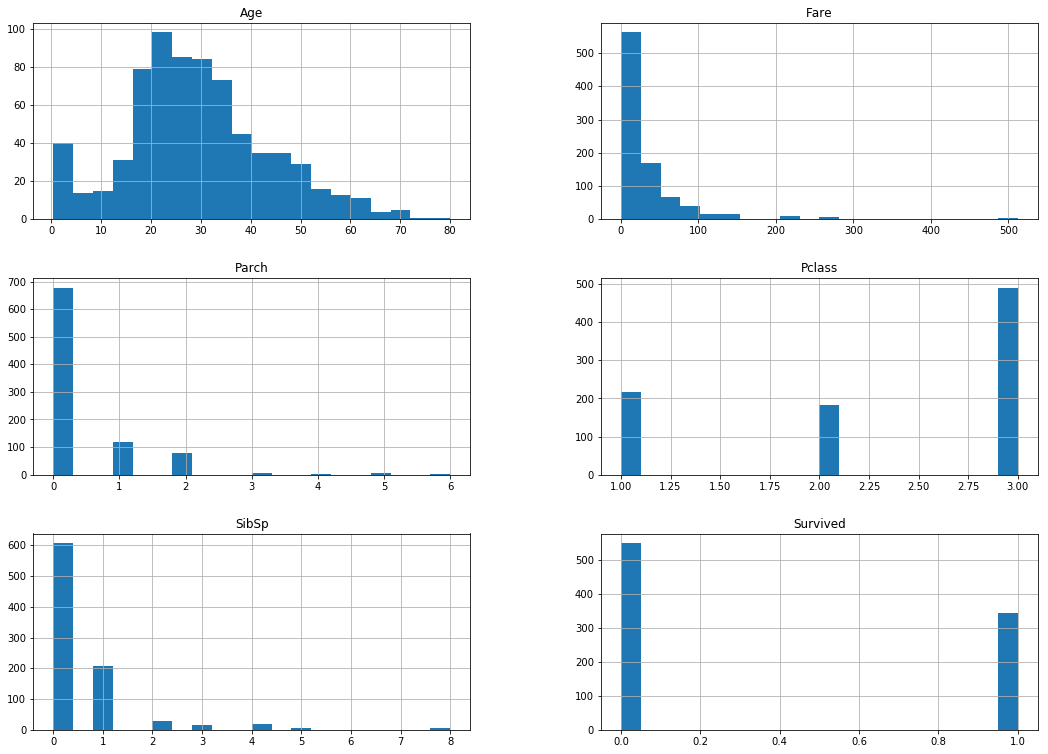

In [10]:
%matplotlib inline 
import matplotlib.pyplot as plt

titanic_train.hist(bins=20, figsize=(18, 13))
plt.show()

We notice a few things in these histograms: 
- `Age` distribution is centered around 20-30 years old group ranging to 80 with quite large number of children aged 0-5; the minimal age value is 0.42 and the maximal is 80; the mean value is 29.6991 with quit large standard deviation of 14.5264; the median value is 28.
- `Fare` attribute values distribution is strongly positevely skewed with mean 32.2042 and large stadard deviation of 49.6934; because the distribution is skewed median is much smaller than the mean with value of 14.4542; the range of data is large ranging from 0 to 512; at the same time 75% of the data is lower than 31. 
- `Parch` (the number of parents/children aboard) distribution mode is 0 by far meaning that most of the passengers traveled without any parents/children and also there are some outlier values with 3 and more parents/children aboard.
- `Pclass` distribution shows that almost 500 out of all 891 passengers in the dataset were travelling the 3rd (lowest) class and almost 200 passengers were travelling both in 1st and 2nd class.
- `SibSp` (number of siblings/spouses aboard) is similar to `Parch` distribution but with larger number of passengers travelling with one sibling/spouse.
- `Survived` obviously shows only two values but we can also see that number of survivors is much smaller than the number of passengers who died in the catastrophy.

Let's also look at catgorical attributes values: `Name`, `Sex`, `Ticket`, `Cabin`, `Embarked`.

In [11]:
titanic_train["Name"].value_counts()

Attalah, Miss. Malake                                                  1
Goodwin, Master. Harold Victor                                         1
Williams, Mr. Leslie                                                   1
Doling, Mrs. John T (Ada Julia Bone)                                   1
Hodges, Mr. Henry Price                                                1
Smith, Miss. Marion Elsie                                              1
Holverson, Mr. Alexander Oskar                                         1
Young, Miss. Marie Grice                                               1
Beckwith, Mr. Richard Leonard                                          1
Beane, Mrs. Edward (Ethel Clarke)                                      1
Long, Mr. Milton Clyde                                                 1
Gill, Mr. John William                                                 1
Cairns, Mr. Alexander                                                  1
Moran, Mr. Daniel J                                

`Names`, by definition, are rather unique so its distribution would be flat. It is not categorical attribute then - just textual. This tells us that in modelling phase this value will not be of too much help since there are no group of values that model can identify.

In [12]:
titanic_train["Ticket"].value_counts()

CA. 2343             7
347082               7
1601                 7
347088               6
3101295              6
CA 2144              6
S.O.C. 14879         5
382652               5
113781               4
W./C. 6608           4
17421                4
4133                 4
113760               4
19950                4
2666                 4
349909               4
347077               4
PC 17757             4
LINE                 4
363291               3
345773               3
239853               3
F.C.C. 13529         3
35273                3
248727               3
230080               3
110152               3
13502                3
C.A. 34651           3
29106                3
                    ..
364850               1
113509               1
371362               1
SC 1748              1
113767               1
113783               1
29751                1
12460                1
SC/PARIS 2149        1
11813                1
C.A. 6212            1
PC 17585             1
29108      

`Ticket` attribute is also not a classical categorical attribute with multiple unique or close to unoque values. There some values repetition but rather tickets identifiers (as we assume they are) are rather unique. This again can lead to the conclusion that this data will not be helpful in survival prediction model.

In [13]:
titanic_train["Cabin"].value_counts()

C23 C25 C27        4
G6                 4
B96 B98            4
F2                 3
D                  3
F33                3
C22 C26            3
E101               3
B57 B59 B63 B66    2
C124               2
E67                2
B35                2
C93                2
E44                2
E33                2
B77                2
C92                2
D26                2
C78                2
D17                2
C2                 2
F4                 2
B20                2
E121               2
C65                2
D33                2
D20                2
C52                2
D36                2
B18                2
                  ..
E46                1
B3                 1
C99                1
D7                 1
C128               1
F G63              1
B50                1
B82 B84            1
C86                1
E49                1
B73                1
A26                1
C70                1
B37                1
B86                1
A32                1
C49          

`Cabin` is similar in structure to the `Name` and `Ticket` attributes. It is again rather textual attribute and note categorical. As we also seen earlier this is the attribute with the biggest number of missing data: we have only 204 values out of all 891 passengers and the rest is missing. All this suggest that also this attribute will not be of much help during the modeling phase of this project.

In [14]:
titanic_train["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

`Sex` attribute has only two possible values: `male` and `female`. It is a categorical attribute. Let's plot it.

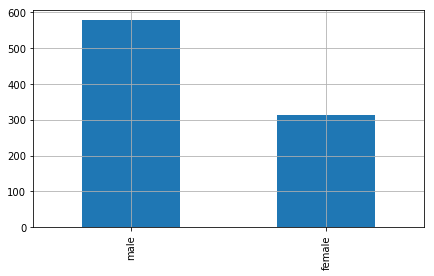

In [15]:
titanic_train["Sex"].value_counts().plot(kind='bar', figsize=(7, 4), grid=True)

We see that on Titanic (as measured by analysed dataset) there were almost twice as much males than females.

In [16]:
titanic_train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

`Embarked` attribute has three possible values: `S`, `C` and `Q` (standing for Southampton, Cherbourg or Queenstown city of embarkation) meaning that it is categorical attribute. Let's plot it's values.

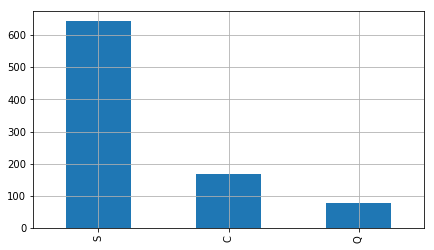

In [17]:
titanic_train["Embarked"].value_counts().plot(kind='bar', figsize=(7, 4), grid=True)

We can see that vast majority of passengers embarked in Southampton port, less than 200 passengers embarked in Cherbourg and less then embarked in Queenstown. For now we can tell nothing more out of it but later on we will try to see how this attribute values affected the survival chances of passengers.

It looks like we have 7 attributes that we can explore for how their values affect pasengers the survival chances. These are the five numerical attributes: `Pclass` (passenger class), `Age` (passenger age), `SibSp` (number of siblings/spouses aboard), `Parch` (number of parents/children aboard), `Fare` (fare passenger paid). There are also two categorical attributes that looks like factors that can be analysed for influencing passengers survival chances: `Sex` (passenger sex) and `Embarked` (port of embarkation). 

In further analysis and modelling we will concentrate on these attributes when analysing and modeling passengers survival chances. `Name`, `Ticket` and `Cabin` attributes are textual non-categorical and rather unique values and as such are hard to analyze in terms of finding some patterns or relations between them and our target `Survived` attribute.

As a sidenote `Sex` and `Embarked`, as categorical values, can be numerically encoded. We will perform this when preparing the data for modeling stage.

We can finish now studying individual attributes properties and start looking at relations between them.

In [18]:
titanic_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 3.2 Relations between attributes analysis

Let's now dig deeper into data internal structure and values. Since our dataset is not very large we can create scatter plot between each of the numerical attributes.

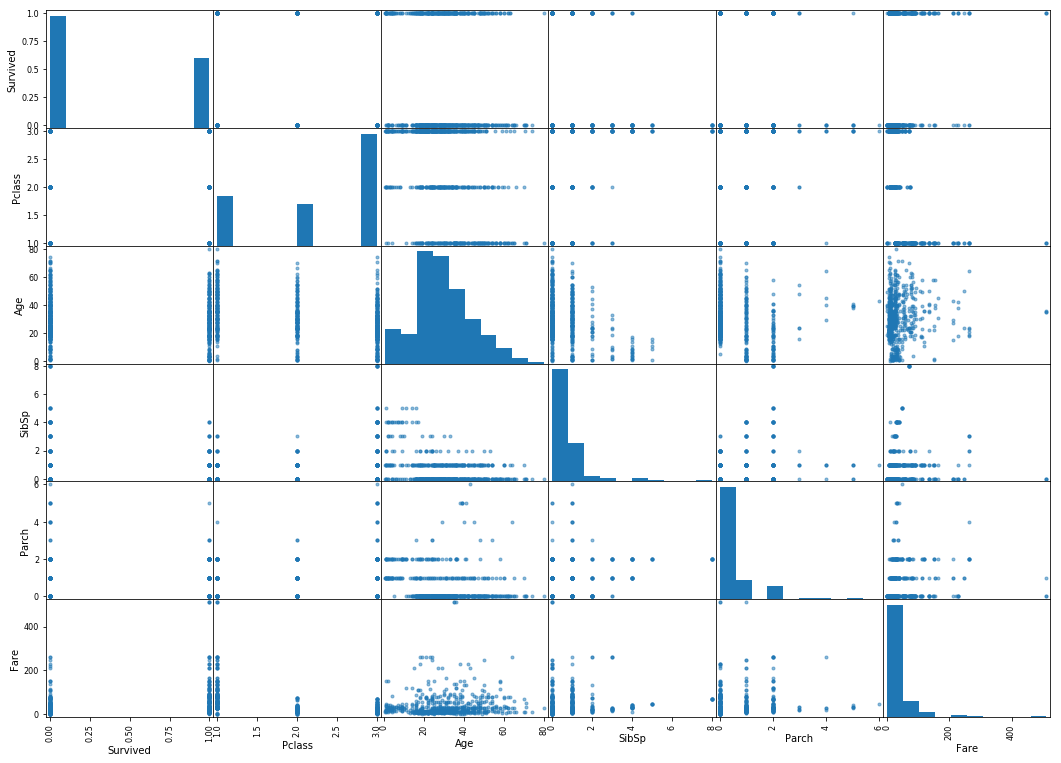

In [19]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(titanic_train, figsize=(18, 13))
plt.show()

It is quite difficult to read something informative from scatter plots since some of the data is not continous.

Let's then compute the correlation matrix showing value for correlation coefficient between each numerical attribute.

In [20]:
corr_matrix = titanic_train.corr()
corr_matrix

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


We can see some meaningful correlations here. To get even better intuition let's visualize the correlation matrix.

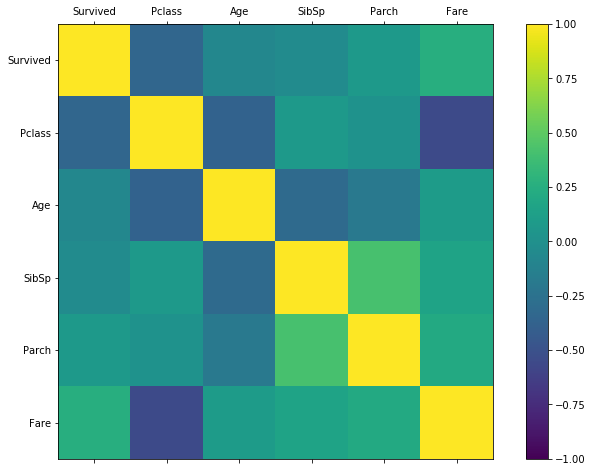

In [21]:
fig, axes = plt.subplots(figsize=(12, 8))
cax = axes.matshow(corr_matrix, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(corr_matrix), 1)
axes.set_xticks(ticks)
axes.set_yticks(ticks)
axes.set_xticklabels(corr_matrix)
axes.set_yticklabels(corr_matrix)
plt.show()

Analyzing correlation let's remember that our target value is `Survived` attribute. Let's concentrate for now on correlation between target value and other attributes. We see quite stron positive correlation between `Fare` and `Survived` attributes values (0.2573) meaning that who payed more for the ticked could have for some reason higher chances for survival. There is also quite strong negative correlation between `Pclass` and `Survived` attributes values (-0.3385) similarly meaning that the higher class passenger was travelling the lower was risk for not surviving. The rest of the attributes seems not correlated with `Survived`. 

Looking on other at relations between other attributes an obvious intution is strong negative correlation between `Pclass` and `Fare` (-0.5495): the more expensive ticket usually means better standard and lower class number (1st class is the most luxourious).

Other interesting insight is quite strong positive correlation between `SibSp` and `Parch` attributes meaning that someone who tends to travel with siblings or spouse tends to also travel with parents or children.

Surprising is positive correlation between `Parch` and `Fare` attributes (0.2162) meaning that person traveling with parents or children tends to pay more for the ticket. Similar but with lower correlation in case of `SibSp` attribute.

Other more distinct relation we can see in the dataset is negative correlation between `Pclass` and `Age` (-0.3692). We can interpret is as the lower class number the higher age which seems reasonable.

Also interesting is the high negative correlation between `Age` and `SibSp` (-0.3083). It conveys interesting fact that the older passenger was the lower was the number of siblings travelling with.

We now have quite deep insight in what is going on, in general, in the dataset. 

Now we will proceed to answering question posed at the begining of this analysis.

### 3.3 What was Titanic passengers demographic structure analyzed in terms of attributes?

We will conduct this part of analysis in terms of attributes we found meaningful, that is: `Pclass`, `Sex`, `Age`, `SibSp`, `Parch`, `Fare` and `Embarked`.

Let's start with ticket class analysis - how many passengers travelled in each of the ticket classes. On Titanic there were three tickets classes: first, second and third. They are represented in the dataset using values 1, 2 and 3.  


In [22]:
titanic_class_counts = titanic_train["Pclass"].value_counts(sort=False)
titanic_class_counts

1    216
2    184
3    491
Name: Pclass, dtype: int64

Let's see how does this population of passengers looks like.

In [23]:
def get_waffle_plot(data, rows, title):
    colors=("#f1b7b0", "#f0f0f0", "#e3d8c0", "#f9d9ac", "#f1b7b0", "#f0f0f0", "#e3d8c0", "#f9d9ac")
    fig = plt.figure(
        FigureClass=Waffle, 
        rows=rows,
        values=data, 
        colors=colors[:len(data)],
        title={'label': title, 'loc': 'left'},
        figsize=(20, 4),
        labels=["{} ({} passengers, {:.2f}%)".format(k, v, v / sum(data.values()) * 100) for k, v in data.items()],
        legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.3), 'ncol': len(data), 'framealpha': 0, "fontsize": 14, "handlelength": 0.7}
)
    plt.show()


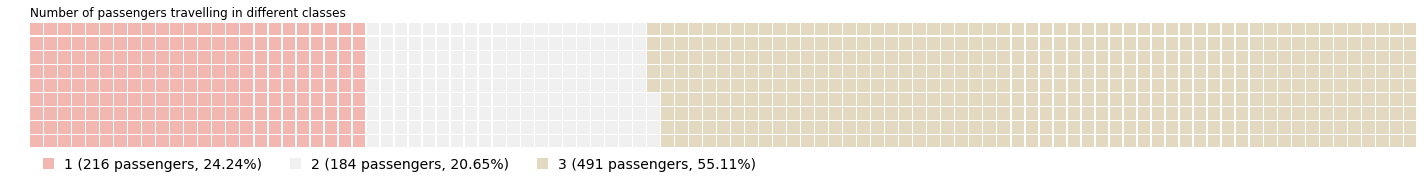

In [24]:
get_waffle_plot(titanic_class_counts.to_dict(), rows=9, title="Number of passengers travelling in different classes")

We see that vast majority (55.11%) of passengers travelled in lowest third class and almost the quarter of passengers travelled in first class. 

How did females and males passengers numbers look like?

In [25]:
titanic_sex_counts = titanic_train["Sex"].value_counts()
titanic_sex_counts

male      577
female    314
Name: Sex, dtype: int64

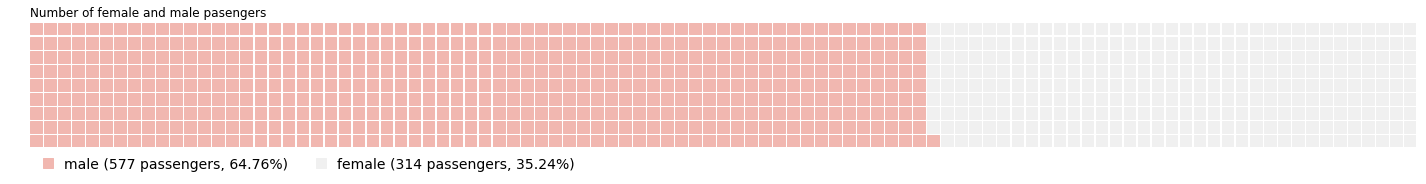

In [26]:
get_waffle_plot(titanic_sex_counts.to_dict(), rows=9, title="Number of female and male pasengers")

Majority of all passengers were males (64.76%) with onlye 35.24% of females.

To analyze age we first need to bin data into meaningful age groups.

In [27]:
titanic_age_groups_counts = pd.cut(titanic_train["Age"], bins=[0, 14, 24, 34, 44, 54, 64, 80]).value_counts().sort_index()
titanic_age_groups_counts

(0, 14]      77
(14, 24]    200
(24, 34]    201
(34, 44]    121
(44, 54]     73
(54, 64]     31
(64, 80]     11
Name: Age, dtype: int64

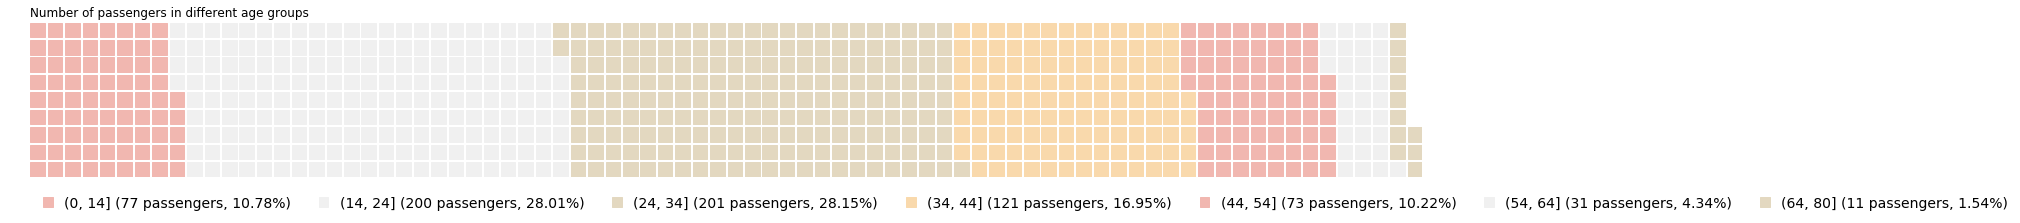

In [28]:
get_waffle_plot(titanic_age_groups_counts.to_dict(), rows=9, title="Number of passengers in different age groups")

In [29]:
titanic_sibsp_counts = titanic_train["SibSp"].value_counts()
titanic_sibsp_counts

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

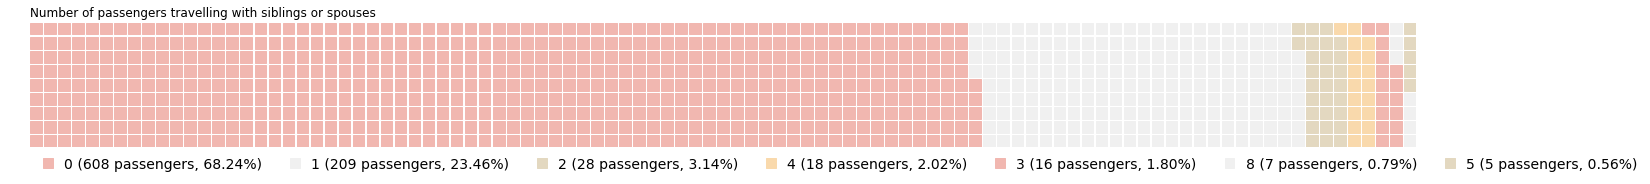

In [30]:
get_waffle_plot(titanic_sibsp_counts.to_dict(), rows=9, title="Number of passengers travelling with siblings or spouses")

In [31]:
titanic_parch_counts = titanic_train["Parch"].value_counts()
titanic_parch_counts

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

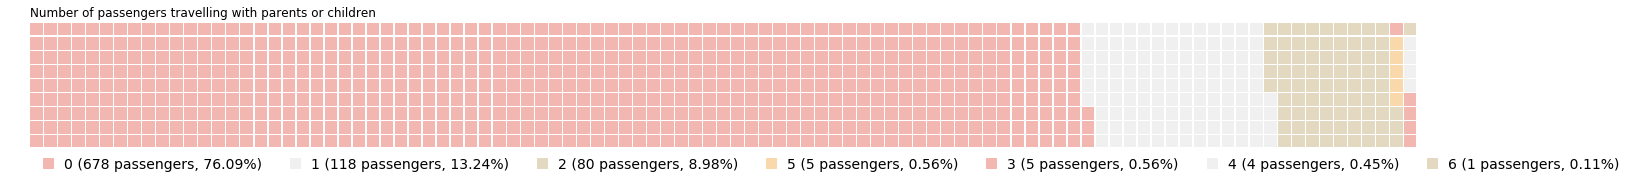

In [32]:
get_waffle_plot(titanic_parch_counts.to_dict(), rows=9, title="Number of passengers travelling with parents or children")

In [33]:
titanic_fare_groups_counts = pd.cut(titanic_train["Fare"], bins=[0, 20, 40, 60, 80, 100, 300, 600]).value_counts().sort_index()
titanic_fare_groups_counts

(0, 20]       500
(20, 40]      200
(40, 60]       54
(60, 80]       48
(80, 100]      21
(100, 300]     50
(300, 600]      3
Name: Fare, dtype: int64

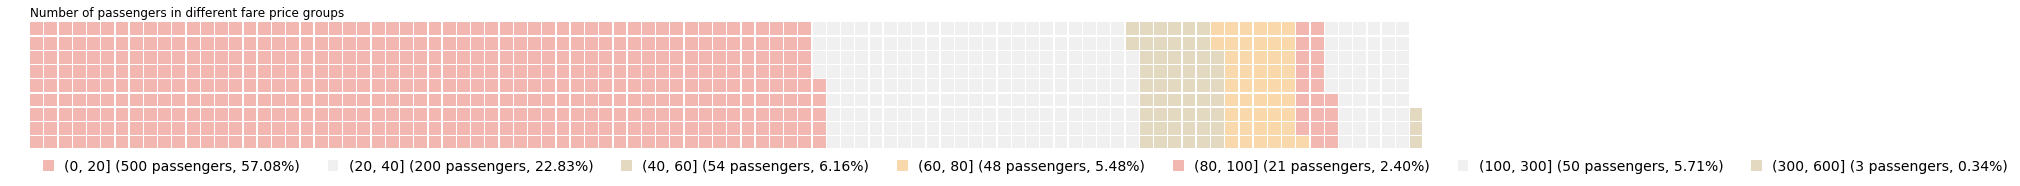

In [34]:
get_waffle_plot(titanic_fare_groups_counts.to_dict(), rows=9, title="Number of passengers in different fare price groups")

In [35]:
titanic_embarked_counts = titanic_train["Embarked"].value_counts()
titanic_embarked_counts

S    644
C    168
Q     77
Name: Embarked, dtype: int64

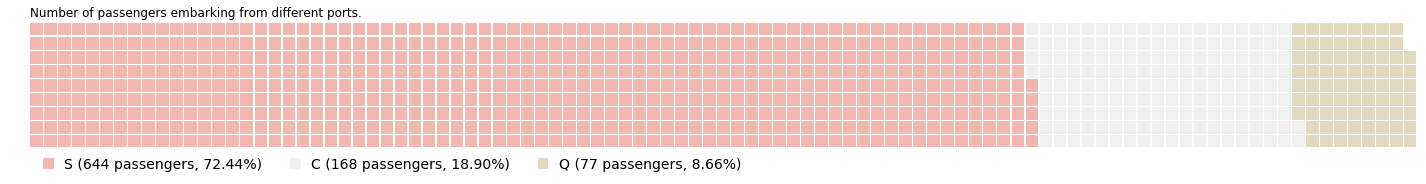

In [36]:
get_waffle_plot(titanic_embarked_counts.to_dict(), rows=9, title="Number of passengers embarking from different ports.")

### 3.4 What is the overall Titanic passengers survival ratio? Is the difference between survived group statistically significant as compared to the rest of population?

We will now answer question what is the overall Titanic passengers survival ratio. To to that we will create survival ratio metric. We will define it as the ratio between the number of survived passengers and the overall number of passengers. We will use this value for later reference and comparison in other attributes analysis.

Our dataset contains 891 passengers data out of all 2224 passengers. This is partly due to the reason that we work with labeled train dataset with separate unlabeled test dataset with 418 passengers data set aside. In this analysis we will treat these 891 passengers not as a sample but rather as our whole population of 891 passengers. The same assumption will apply to subsequent parts of this analysis.

Let's now see what is the total number of survived passengers and and those who did not survive. 

In [37]:
titanic_survived_counts = titanic_train["Survived"].value_counts(sort=False)
titanic_survived_counts

0    549
1    342
Name: Survived, dtype: int64

Let's visualize it.

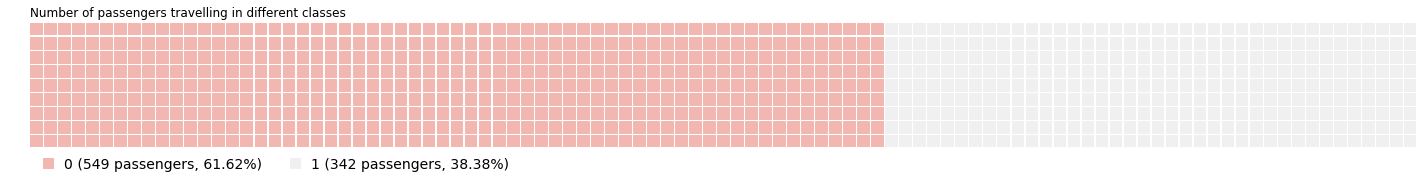

In [38]:
get_waffle_plot(titanic_survived_counts.to_dict(), rows=9, title="Number of passengers travelling in different classes")

Let's also create overall survival ratio metric.

In [39]:
def get_survival_ratio(passengers_df):
    return passengers_df["Survived"].sum() / passengers_df["Survived"].count()

In [40]:
survival_ratio = get_survival_ratio(titanic_train)
survival_ratio

0.38383838383838381

We see that from Titanic 891 passengers only 342 survived and 549 died. The Titanic survival ratio is approximately 0.3838, meaning that only 38.38% of all passengers (again, we are talking here about population of passengers in the dataset) survived the catastrophy. That is really small percentage. 

Again we can see that majority of Titanic passengers died in the catastrophy. Let's keep these values - especially the overal survival ratio metric among all Titanic passengers of 0.3838 - as a reference point for further analysis.

Let's this value as reference.


### 3.5 What is the survival ratio for different demographic passengers groups? Which groups have biggest chances for survival and which smallest? Were the differences between the most distinct groups statistically significant? 

Let's now finally see how survival ratio changes in groups belonging to attributes demographic sub-categories. In this analysis we will process the same attributes as in 3.3 part: `Pclass`, `Sex`, `Age`, `SibSp`, `Parch`, `Fare` and `Embarked`. 

We will start by grouping dataset using each of the attributes unique values. Later, based on these grouped values, we will calculate survival ratio for each of the attributes sub-groups.

In [56]:
titanic_pclass_group = titanic_train.groupby("Pclass")
titanic_pclass_group.groups

{1: Int64Index([  2,   4,   7,  12,  24,  28,  31,  32,  35,  36,
             ...
             854, 857, 858, 863, 868, 872, 873, 880, 888, 890],
            dtype='int64', name='PassengerId', length=216),
 2: Int64Index([ 10,  16,  18,  21,  22,  34,  42,  44,  54,  57,
             ...
             849, 855, 862, 865, 866, 867, 875, 881, 884, 887],
            dtype='int64', name='PassengerId', length=184),
 3: Int64Index([  1,   3,   5,   6,   8,   9,  11,  13,  14,  15,
             ...
             876, 877, 878, 879, 882, 883, 885, 886, 889, 891],
            dtype='int64', name='PassengerId', length=491)}

In [57]:
titanic_sex_group = titanic_train.groupby("Sex")
titanic_sex_group.groups

{'female': Int64Index([  2,   3,   4,   9,  10,  11,  12,  15,  16,  19,
             ...
             867, 872, 875, 876, 880, 881, 883, 886, 888, 889],
            dtype='int64', name='PassengerId', length=314),
 'male': Int64Index([  1,   5,   6,   7,   8,  13,  14,  17,  18,  21,
             ...
             874, 877, 878, 879, 882, 884, 885, 887, 890, 891],
            dtype='int64', name='PassengerId', length=577)}

In case of `Age` attribute we will group its values into age groups as we did previously in demographic analysis.

In [92]:
titanic_age_group = titanic_train.groupby(pd.cut(titanic_train["Age"], bins=[0, 14, 24, 34, 44, 54, 64, 80]))
titanic_age_group.groups

{'(0, 14]': Int64Index([  8,  10,  11,  15,  17,  25,  40,  44,  51,  59,  60,  64,  79,
             120, 126, 148, 165, 166, 172, 173, 183, 184, 185, 194, 206, 234,
             238, 262, 279, 298, 306, 341, 349, 375, 382, 387, 408, 420, 436,
             446, 447, 449, 470, 480, 481, 490, 531, 536, 542, 543, 550, 619,
             635, 643, 645, 684, 687, 692, 721, 732, 751, 752, 756, 778, 781,
             788, 789, 803, 804, 814, 820, 825, 828, 832, 851, 853, 870],
            dtype='int64', name='PassengerId'),
 '(14, 24]': Int64Index([  1,  13,  23,  28,  38,  39,  45,  50,  52,  57,
             ...
             854, 856, 859, 862, 865, 876, 877, 878, 883, 888],
            dtype='int64', name='PassengerId', length=200),
 '(24, 34]': Int64Index([  3,   9,  19,  22,  24,  35,  42,  54,  58,  67,
             ...
             871, 873, 875, 881, 882, 884, 885, 887, 890, 891],
            dtype='int64', name='PassengerId', length=201),
 '(34, 44]': Int64Index([  2,   4,   5,  14, 

In [68]:
titanic_sibsp_group = titanic_train.groupby("SibSp")
titanic_sibsp_group.groups

{0: Int64Index([  3,   5,   6,   7,   9,  12,  13,  15,  16,  18,
             ...
             881, 882, 883, 884, 885, 886, 887, 888, 890, 891],
            dtype='int64', name='PassengerId', length=608),
 1: Int64Index([  1,   2,   4,  10,  11,  14,  19,  26,  32,  35,
             ...
             850, 853, 855, 857, 862, 867, 870, 872, 875, 889],
            dtype='int64', name='PassengerId', length=209),
 2: Int64Index([ 39,  49,  70, 105, 121, 148, 184, 246, 302, 312, 331, 334, 393,
             437, 438, 449, 470, 530, 566, 572, 601, 619, 645, 656, 661, 666,
             743, 861],
            dtype='int64', name='PassengerId'),
 3: Int64Index([8, 25, 28, 64, 86, 89, 177, 230, 342, 375, 410, 486, 635, 643, 727,
             820],
            dtype='int64', name='PassengerId'),
 4: Int64Index([ 17,  51,  69, 120, 165, 172, 183, 234, 262, 267, 279, 542, 543,
             687, 788, 814, 825, 851],
            dtype='int64', name='PassengerId'),
 5: Int64Index([60, 72, 387, 481, 68

In [70]:
titanic_parch_group = titanic_train.groupby("Parch")
titanic_parch_group.groups

{0: Int64Index([  1,   2,   3,   4,   5,   6,   7,  10,  12,  13,
             ...
             878, 879, 882, 883, 884, 885, 887, 888, 890, 891],
            dtype='int64', name='PassengerId', length=678),
 1: Int64Index([  8,  11,  17,  25,  51,  55,  66,  98,  99, 103,
             ...
             836, 849, 853, 854, 856, 857, 870, 872, 880, 881],
            dtype='int64', name='PassengerId', length=118),
 2: Int64Index([  9,  28,  44,  59,  60,  64,  69,  72,  79,  89,  94, 120, 137,
             141, 148, 149, 154, 160, 166, 181, 183, 185, 202, 234, 238, 248,
             255, 256, 262, 298, 306, 312, 319, 325, 342, 378, 382, 387, 391,
             395, 418, 420, 436, 437, 446, 451, 473, 481, 499, 507, 534, 536,
             540, 541, 542, 543, 551, 586, 594, 609, 616, 635, 643, 660, 684,
             686, 743, 755, 764, 784, 789, 793, 803, 814, 820, 828, 847, 851,
             864, 889],
            dtype='int64', name='PassengerId'),
 3: Int64Index([87, 438, 737, 775, 859], dt

And also like in demographic analysis we will binnarize the `Fare` attribute values.

In [75]:
titanic_fare_group = titanic_train.groupby(pd.cut(titanic_train["Fare"], bins=[0, 20, 40, 60, 80, 100, 300, 600]))
titanic_fare_group.groups

{'(0, 20]': Int64Index([  1,   3,   5,   6,   9,  11,  13,  15,  16,  18,
             ...
             876, 877, 878, 879, 882, 883, 884, 885, 887, 891],
            dtype='int64', name='PassengerId', length=500),
 '(100, 300]': Int64Index([ 28,  32,  89, 119, 196, 216, 269, 270, 298, 300, 306, 307, 308,
             312, 319, 320, 326, 333, 335, 338, 342, 374, 378, 381, 391, 394,
             436, 439, 499, 506, 528, 538, 545, 551, 558, 582, 610, 660, 661,
             690, 699, 701, 709, 717, 731, 743, 764, 780, 803, 857],
            dtype='int64', name='PassengerId'),
 '(20, 40]': Int64Index([  8,  10,  12,  14,  17,  21,  24,  25,  26,  31,
             ...
             854, 855, 858, 863, 875, 881, 886, 888, 889, 890],
            dtype='int64', name='PassengerId', length=200),
 '(300, 600]': Int64Index([259, 680, 738], dtype='int64', name='PassengerId'),
 '(40, 60]': Int64Index([  4,   7,  36,  44,  60,  72,  75,  84, 111, 138, 167, 170, 186,
             249, 310, 330, 357, 37

In [77]:
titanic_embarked_group = titanic_train.groupby("Embarked")
titanic_embarked_group.groups

{'C': Int64Index([  2,  10,  20,  27,  31,  32,  35,  37,  40,  43,
             ...
             848, 850, 853, 859, 860, 867, 875, 876, 880, 890],
            dtype='int64', name='PassengerId', length=168),
 'Q': Int64Index([  6,  17,  23,  29,  33,  45,  47,  48,  83, 110, 117, 127, 144,
             157, 172, 187, 189, 197, 199, 209, 215, 242, 246, 261, 265, 275,
             279, 281, 290, 301, 302, 304, 323, 331, 359, 360, 365, 369, 389,
             412, 413, 422, 429, 460, 469, 502, 503, 511, 518, 526, 553, 561,
             574, 594, 613, 614, 627, 630, 654, 655, 658, 681, 698, 704, 719,
             728, 750, 768, 769, 777, 779, 788, 791, 826, 829, 886, 891],
            dtype='int64', name='PassengerId'),
 'S': Int64Index([  1,   3,   4,   5,   7,   8,   9,  11,  12,  13,
             ...
             878, 879, 881, 882, 883, 884, 885, 887, 888, 889],
            dtype='int64', name='PassengerId', length=644)}

With passengers data grouped with all meaningful attributes we can now proceed with calculating survival ration for each of the group.

In [87]:
titanic_pclass_survival_ratio = titanic_pclass_group.apply(get_survival_ratio)
titanic_pclass_survival_ratio

Pclass
1    0.629630
2    0.472826
3    0.242363
dtype: float64

We can clearly see here that passengers from first class were much more likely to survive.

In [90]:
titanic_sex_survival_ratio = titanic_sex_group.apply(get_survival_ratio)
titanic_sex_survival_ratio

Sex
female    0.742038
male      0.188908
dtype: float64

In [93]:
titanic_age_survival_ratio = titanic_age_group.apply(get_survival_ratio)
titanic_age_survival_ratio

Age
(0, 14]     0.584416
(14, 24]    0.365000
(24, 34]    0.388060
(34, 44]    0.421488
(44, 54]    0.410959
(54, 64]    0.387097
(64, 80]    0.090909
dtype: float64

In [94]:
titanic_sibsp_survival_ratio = titanic_sibsp_group.apply(get_survival_ratio)
titanic_sibsp_survival_ratio

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
dtype: float64

In [95]:
titanic_parch_survival_ratio = titanic_parch_group.apply(get_survival_ratio)
titanic_parch_survival_ratio

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
dtype: float64

In [96]:
titanic_fare_survival_ratio = titanic_fare_group.apply(get_survival_ratio)
titanic_fare_survival_ratio

Fare
(0, 20]       0.284000
(20, 40]      0.430000
(40, 60]      0.574074
(60, 80]      0.520833
(80, 100]     0.857143
(100, 300]    0.720000
(300, 600]    1.000000
dtype: float64

Almost like a linear relationship - the more passenger paid for the ticket the higher chances for survival she or he had.

In [97]:
titanic_embarked_survival_ratio = titanic_embarked_group.apply(get_survival_ratio)
titanic_embarked_survival_ratio

Embarked
C    0.553571
Q    0.389610
S    0.336957
dtype: float64

Let's now visualize and analyze these results. As a reference we will also add here an overall titanic survival ratio.

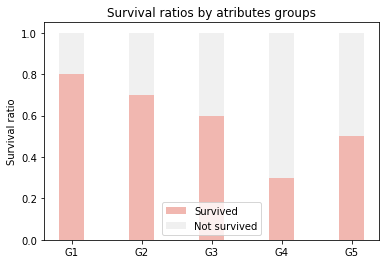

In [103]:
N = 5
survival_ratios = np.array([0.8, 0.7, 0.6, 0.3, 0.5])
labels = ('G1', 'G2', 'G3', 'G4', 'G5')
ind = np.arange(N)
width = 2 / len(survival_ratios)

p1 = plt.bar(ind, survival_ratios, width, color='#f1b7b0')
p2 = plt.bar(ind, 1 - survival_ratios, width, bottom=survival_ratios, color='#f0f0f0')

plt.ylabel('Survival ratio')
plt.title('Survival ratios by atributes groups')
plt.xticks(ind, labels)
# plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Survived', 'Not survived'))

plt.show()

In [32]:
passengers_titanic_grouped = titanic_train.groupby("Pclass")

In [33]:
pclass_survival_metrics = passengers_titanic_grouped.apply(get_survival_metrics)

Let's see the survival metrics for passengers belonging to individual classes.

In [34]:
pclass_survival_metrics[1]

{'not_survived_num': 80,
 'survival_ratio': 0.62962962962962965,
 'survived_num': 136,
 'total_num': 216}

In [35]:
pclass_survival_metrics[2]

{'not_survived_num': 97,
 'survival_ratio': 0.47282608695652173,
 'survived_num': 87,
 'total_num': 184}

In [36]:
pclass_survival_metrics[3]

{'not_survived_num': 372,
 'survival_ratio': 0.24236252545824846,
 'survived_num': 119,
 'total_num': 491}

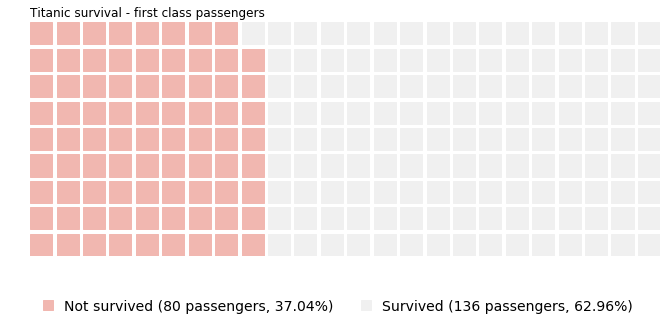

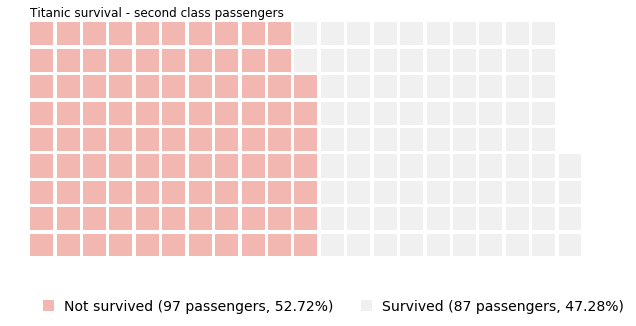

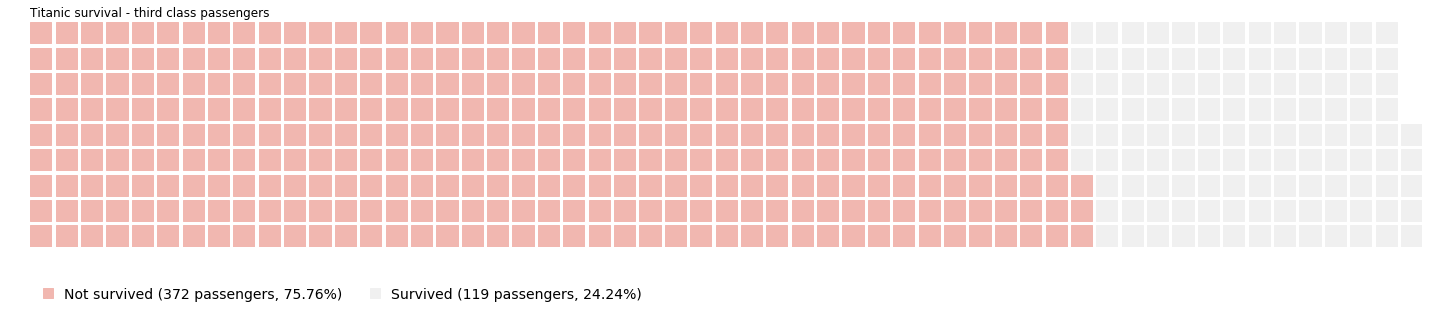

In [247]:
data = {'Not survived': pclass_survival_metrics[1]["not_survived_num"], 
        'Survived': pclass_survival_metrics[1]["survived_num"]}
colors=("#f1b7b0", "#f0f0f0")
get_waffle_plot(data, colors, rows=9, title="Titanic survival - first class passengers")

data = {'Not survived': pclass_survival_metrics[2]["not_survived_num"], 
        'Survived': pclass_survival_metrics[2]["survived_num"]}
colors=("#f1b7b0", "#f0f0f0")
get_waffle_plot(data, colors, rows=9, title="Titanic survival - second class passengers")

data = {'Not survived': pclass_survival_metrics[3]["not_survived_num"], 
        'Survived': pclass_survival_metrics[3]["survived_num"]}
colors=("#f1b7b0", "#f0f0f0")
get_waffle_plot(data, colors, rows=9, title="Titanic survival - third class passengers")

### 3.5 Did being male or female made chances for survival higher or lower (`Sex` attribute survival analysis)?

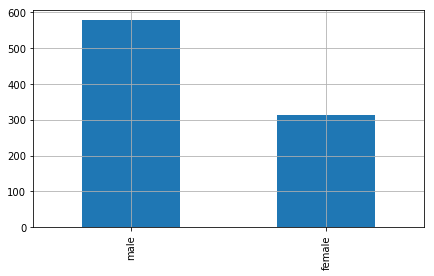

In [251]:
titanic_train["Sex"].value_counts().plot(kind='bar', figsize=(7, 4), grid=True)

In [252]:
sex_value_counts = titanic_train["Sex"].value_counts()
sex_value_counts

male      577
female    314
Name: Sex, dtype: int64

In [37]:
data = {'Females': sex_value_counts["female"], 'Males': sex_value_counts["male"]}
colors=("#f1b7b0", "#f0f0f0")
get_waffle_plot(data, colors, rows=9, title="Titanic females and males number")

NameError: name 'sex_value_counts' is not defined

In [271]:
sex_titanic_grouped = titanic_train.groupby("Sex")

In [272]:
sex_survival_metrics = sex_titanic_grouped.apply(get_survival_metrics)

In [273]:
sex_survival_metrics

Sex
female    {'total_num': 314, 'survived_num': 233, 'not_s...
male      {'total_num': 577, 'survived_num': 109, 'not_s...
dtype: object

In [275]:
sex_survival_metrics["female"]

{'not_survived_num': 81,
 'survival_ratio': 0.7420382165605095,
 'survived_num': 233,
 'total_num': 314}

In [274]:
sex_survival_metrics["male"]

{'not_survived_num': 468,
 'survival_ratio': 0.18890814558058924,
 'survived_num': 109,
 'total_num': 577}

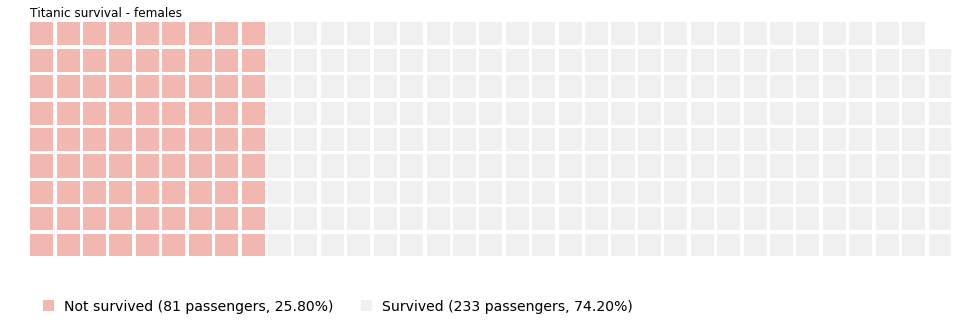

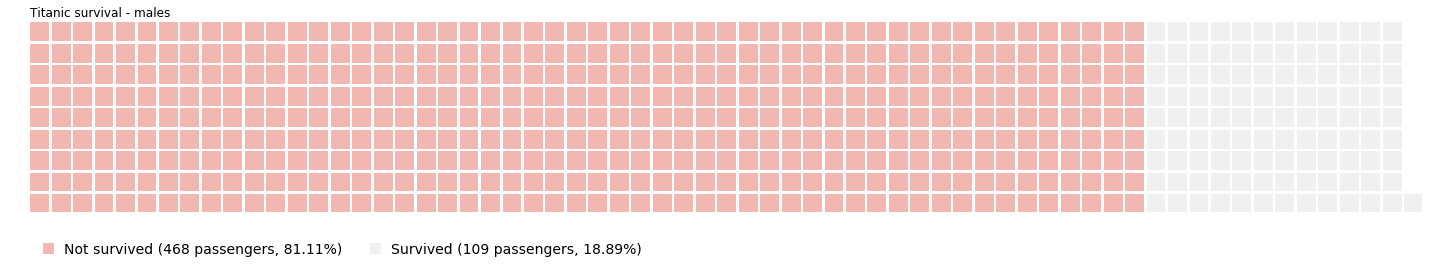

In [277]:
data = {'Not survived': sex_survival_metrics["female"]["not_survived_num"], 
        'Survived': sex_survival_metrics["female"]["survived_num"]}
colors=("#f1b7b0", "#f0f0f0")
get_waffle_plot(data, colors, rows=9, title="Titanic survival - females")

data = {'Not survived': sex_survival_metrics["male"]["not_survived_num"], 
        'Survived': sex_survival_metrics["male"]["survived_num"]}
colors=("#f1b7b0", "#f0f0f0")
get_waffle_plot(data, colors, rows=9, title="Titanic survival - males")


### 3.3 What is the overall Titanic passengers survival ratio - `Survive` attribute analysis?



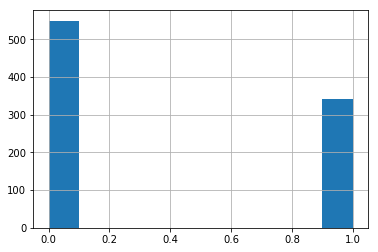

0    549
1    342
Name: Survived, dtype: int64

{'not_survived_num': 549,
 'survival_ratio': 0.38383838383838381,
 'survived_num': 342,
 'total_num': 891}

NameError: name 'not_survived_num' is not defined

## 4. Prepare the data

We will now prepare the data for machine learning modelling.

Let's start by separating the predictors and labels since we do not want to apply the same transformations to both.

In [20]:
titanic_pred = titanic_train.drop("Survived", axis=1)
titanic_labels = titanic_train["Survived"].copy()

In [21]:
titanic_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 76.6+ KB


Two attributes seems to be meaningles for machine learning model are `PassengerId` and `Name` which is why let's drop this column. As we have seen earlier analysing text attributes unique values also `Ticket` attribute seems to be meaningless so we also drop its values.

In [22]:
titanic_pred = titanic_pred.drop(["Name", "Ticket"], axis=1)

In [23]:
titanic_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 62.6+ KB


Now we need to deal with missing values we found in the dataset. 

Again the most missing value are in `Cabin` column. That column seems not so much informative and the data if rather scarse which would suggesting droping this feature from the training data set. 


In [24]:
titanic_pred = titanic_pred.drop("Cabin", axis=1)

In `Embarked` column features we miss only two values so we can easily drop these two cases.

In [25]:
indexes_to_drop = titanic_pred[titanic_pred["Embarked"].isnull()].index.values
titanic_pred = titanic_pred.drop(indexes_to_drop, axis=0)
titanic_labels = titanic_labels.drop(indexes_to_drop, axis=0)
titanic_pred = titanic_pred.reset_index(drop=True)
titanic_labels = titanic_labels.reset_index(drop=True)

We have also a lot of missing values in `Age` column however this column seems crucial for our analysis. As starter we decide to fill missing values with median value. Other option is to throw away passengers with missing `Age` value, but considering that it is over 80  passengers data record we would like not to do it. 

Median can only be computed on numerical attributes, so we need to make a copy of the data - one containing only numerical data and one containing only categorical data.

In [26]:
titanic_pred_num = titanic_pred.drop(["Sex", "Embarked"], axis=1)
titanic_pred_cat = titanic_pred[["Sex", "Embarked"]]

We have now only 2 categorical attributes since we dropped `Name` (meaningless), `Cabin` (to many missing values) and `Ticket` (meaningless) attributes.

Let's now use Scikit-Learn Imputer class to fill `Age` attribute missing values and to standardize all values.

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer 

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
#     ('std_scaler', StandardScaler()),
])
titanic_pred_num_prepared = num_pipeline.fit_transform(titanic_pred_num)

In [28]:
titanic_pred_num_prepared

array([[  3.    ,  22.    ,   1.    ,   0.    ,   7.25  ],
       [  1.    ,  38.    ,   1.    ,   0.    ,  71.2833],
       [  3.    ,  26.    ,   0.    ,   0.    ,   7.925 ],
       ..., 
       [  3.    ,  28.    ,   1.    ,   2.    ,  23.45  ],
       [  1.    ,  26.    ,   0.    ,   0.    ,  30.    ],
       [  3.    ,  32.    ,   0.    ,   0.    ,   7.75  ]])

We have all our numerical attributes ready to go.

Let's now take care of out categorical attributes values.

In [29]:
titanic_pred_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 2 columns):
Sex         889 non-null object
Embarked    889 non-null object
dtypes: object(2)
memory usage: 14.0+ KB


Since most machine learning algorithms do not deal with text data so well let's convert text labels we have to numbers. We will use one-hot encoding for this job. First we will convert our attributes from text categories to integer categories, then from integer categories to one-hot vectors using the LabelBinarizer class.

In [30]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
titanic_pred_cat_sex_1hot = encoder.fit_transform(titanic_pred_cat["Sex"])
encoder = LabelBinarizer()
titanic_pred_cat_embarked_1hot = encoder.fit_transform(titanic_pred_cat["Embarked"])

We now have all our data prepared. The last thing is to combine it again into one data set.

In [31]:
import numpy as np

titanic_pred_prepared = np.concatenate([titanic_pred_num_prepared, titanic_pred_cat_sex_1hot, titanic_pred_cat_embarked_1hot], axis=1)

## 5. Short-list promising models

Our data is prepared so we are ready to fit multiple quick models to check how they behave. Our measure of success is classification accuracy.

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
log_clf = LogisticRegression()
log_clf.fit(titanic_pred_prepared, titanic_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We will test our model using cross-validation.

In [34]:
from sklearn.model_selection import cross_val_score
cross_val_score(log_clf, titanic_pred_prepared, titanic_labels, cv=3, scoring="accuracy")

array([ 0.79124579,  0.79054054,  0.78378378])

Let's try Stochastic Gradient Descent classifier using Scikit-Learn's SGDClassifier class.

In [35]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(titanic_pred_prepared, titanic_labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

Let's now use cross-validation to validate our model.

In [36]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, titanic_pred_prepared, titanic_labels, cv=3, scoring="accuracy")

array([ 0.62626263,  0.7027027 ,  0.72635135])

Another model will be K-Nearest Neighbors classifier.

In [37]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(titanic_pred_prepared, titanic_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [38]:
cross_val_score(knn_clf, titanic_pred_prepared, titanic_labels, cv=3, scoring="accuracy")

array([ 0.68686869,  0.71283784,  0.71621622])

So far the best results we got from Logistic Regression model. Let's try different polynomials versions of it.

In [39]:
from sklearn.preprocessing import PolynomialFeatures
polynomial_features_2 = PolynomialFeatures(degree=2, include_bias=False)
polynomial_features_4 = PolynomialFeatures(degree=4, include_bias=False)
polynomial_features_8 = PolynomialFeatures(degree=8, include_bias=False)

In [40]:
titanic_pred_prepared_poly_2 = polynomial_features_2.fit_transform(titanic_pred_prepared)
titanic_pred_prepared_poly_4 = polynomial_features_4.fit_transform(titanic_pred_prepared)
titanic_pred_prepared_poly_8 = polynomial_features_8.fit_transform(titanic_pred_prepared)

In [41]:
titanic_pred_prepared.shape

(889, 9)

In [42]:
titanic_pred_prepared_poly_2.shape

(889, 54)

In [43]:
titanic_pred_prepared_poly_4.shape

(889, 714)

In [44]:
titanic_pred_prepared_poly_8.shape

(889, 24309)

In [45]:
log_clf_2 = LogisticRegression()
log_clf_2.fit(titanic_pred_prepared_poly_2, titanic_labels)
cross_val_score(log_clf_2, titanic_pred_prepared_poly_2, titanic_labels, cv=3, scoring="accuracy")

array([ 0.80808081,  0.81418919,  0.81418919])

In [46]:
log_clf_4 = LogisticRegression()
log_clf_4.fit(titanic_pred_prepared_poly_4, titanic_labels)
cross_val_score(log_clf_4, titanic_pred_prepared_poly_4, titanic_labels, cv=3, scoring="accuracy")

array([ 0.7037037 ,  0.72635135,  0.71283784])

In [47]:
log_clf_8 = LogisticRegression()
log_clf_8.fit(titanic_pred_prepared_poly_8, titanic_labels)
cross_val_score(log_clf_8, titanic_pred_prepared_poly_8, titanic_labels, cv=3, scoring="accuracy")

array([ 0.63973064,  0.61486486,  0.67567568])

So using square polynomial features and logistic regression model improves results a bit. Using higher degree polynomials lower accuracy result.

TODO: Check why higher degree polynomial lowers accuracy result in cross-validation. Visualize how the decision boundary looks like.

Let's try another - more complex - model. Now we will use Random Forest classifier.

In [48]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
forest_clf.fit(titanic_pred_prepared, titanic_labels)
cross_val_score(forest_clf, titanic_pred_prepared, titanic_labels, cv=3, scoring="accuracy")

array([ 0.76430976,  0.79391892,  0.80067568])

No we reached a little bit better accuracy in our model.

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge")),
    ])
svm_clf.fit(titanic_pred_prepared, titanic_labels)


Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline((
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=6, coef0=1, C=5))
))
poly_kernel_svm_clf.fit(titanic_pred_prepared, titanic_labels)
cross_val_score(poly_kernel_svm_clf, titanic_pred_prepared, titanic_labels, cv=3, scoring="accuracy")

array([ 0.75420875,  0.80405405,  0.78716216])

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

rbf_kernel_svm_clf = Pipeline((
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
))
rbf_kernel_svm_clf.fit(titanic_pred_prepared, titanic_labels)
cross_val_score(rbf_kernel_svm_clf, titanic_pred_prepared, titanic_labels, cv=3, scoring="accuracy")

array([ 0.61616162,  0.61824324,  0.61824324])

## 6. Fine-tune models

We have two promissing models. Let's try to improve their performance by fine-tuning their parameters.

## 7. Submit solution

In [52]:
titanic_test = pd.read_csv("datasets/test.csv")

In [53]:
titanic_test = titanic_test.drop(["PassengerId", "Name", "Ticket"], axis=1)
titanic_test = titanic_test.drop("Cabin", axis=1)

In [54]:
titanic_test_num = titanic_test.drop(["Sex", "Embarked"], axis=1)
titanic_test_cat = titanic_test[["Sex", "Embarked"]]

In [55]:
titanic_test_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 5 columns):
Pclass    418 non-null int64
Age       332 non-null float64
SibSp     418 non-null int64
Parch     418 non-null int64
Fare      417 non-null float64
dtypes: float64(2), int64(3)
memory usage: 16.4 KB


In [56]:
imputer = Imputer(strategy="median")
imputer.fit(titanic_test_num)
titanic_test_num_prepared = imputer.transform(titanic_test_num)

In [57]:
titanic_test_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
Sex         418 non-null object
Embarked    418 non-null object
dtypes: object(2)
memory usage: 6.6+ KB


In [58]:
encoder = LabelBinarizer()
titanic_test_cat_sex_1hot = encoder.fit_transform(titanic_test_cat["Sex"])
encoder = LabelBinarizer()
titanic_test_cat_embarked_1hot = encoder.fit_transform(titanic_test_cat["Embarked"])

In [59]:
titanic_test_prepared = np.concatenate([titanic_test_num_prepared, titanic_test_cat_sex_1hot, titanic_test_cat_embarked_1hot], axis=1)

In [60]:
final_predictions = forest_clf.predict(titanic_test_prepared)

In [61]:
final_df = pd.DataFrame({'PassengerId': range(892, len(final_predictions)+892), 'Survived': final_predictions})
final_df.to_csv("datasets/submission.csv", index=False)

Your submission scored 0.73205 (position 8732).